In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
from tqdm import tqdm

import torch
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from utils import load_model, save_model, show_images

device = torch.device('cpu')
train = False

# Data

We will be using the MNIST dataset for this demonstration

In [ ]:
data_dir = './data'
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Diffusion and denoising models

The point of this short demonstration is to implement the diffusion model originally proposed in the [this paper](https://arxiv.org/pdf/2006.11239.pdf) with the addition of condition on classes. We shall train it in tandem with a denoising model, after which we shall generate some normal samples and some inpainting samples. 

As the denoising model we shall use a model based on the UNet architecture

In [8]:
from diffusion import DiffusionModel
from denoising import UNet

model = UNet(
    img_channels=1,
    base_channels=32,
    time_emb_dim=32,
    num_classes=10+1,
)
diffusion = DiffusionModel(model, 1000)
diffusion.to(device)

print('model init done')

model init done


# Training 

Now we shall train the model. For this demo we used 25 epochs and a lr=0.001 with an Adam optimizer. 

In [ ]:
def train_ddpm(diffusion, epochs, optimizer, trainloader, train=True, dummy_label_ratio=0.1):
    if not train:
        load_model(diffusion, 'diffusion_model.pth', device)
        return
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()

            batch_size = images.size(0)

            images, labels = images.to(diffusion.device), labels.to(diffusion.device)
            # set 10% of the labels as the dummy label
            label_mask = torch.rand(batch_size) < dummy_label_ratio
            labels[label_mask] = 10
            time = torch.randint(diffusion.timesteps, size=(batch_size,)).to(device)
            loss = diffusion.loss(images, time, labels)
            running_loss += loss.item() / len(trainloader)

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed with a average loss of {running_loss}")
    tools.save_model(diffusion, 'diffusion_model.pth')

train_ddpm(diffusion, 25, torch.optim.Adam(diffusion.parameters(), lr=0.001), trainloader, train)


Model loaded from diffusion_model.pth.


Now we can see how our model recreates the MNIST images, we shall have 8 rows of 11 images, with the labels 0-9 beings the numbers 0-9 and the final one a dummy label. 

In [ ]:
with torch.no_grad():
    rows = 8
    x_shape = (10*rows, 1, 32, 32)
    init_x = torch.randn(*x_shape, device=device)
    labels = torch.cat([torch.arange(11) for _ in range(rows)], dim=0).to(device)
        
    samples = diffusion.sample(x_shape, labels, init_x=init_x)
samples01 = ((samples + 1) / 2).clip(0, 1)
show_images(samples01, cmap='binary', ncol=11)

976it [01:21, 12.07it/s]

# Inpainting

The diffusion model also has an implemented inpainting method, where we give our diffusion model only parts of images and the rest need to be generated. Below is an example of the masked images

Conditioning:


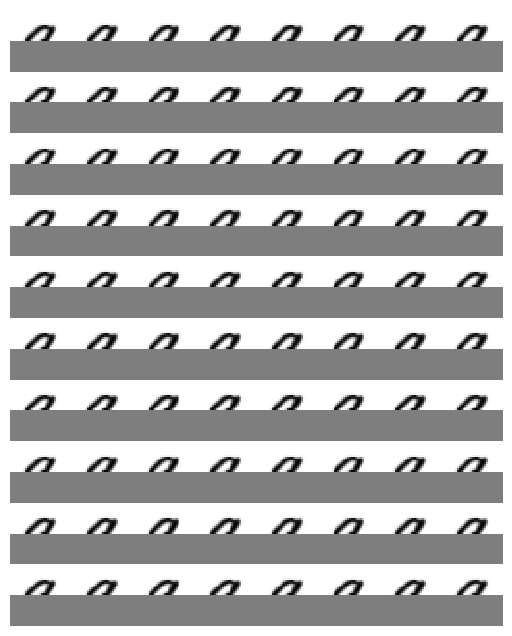

In [ ]:

rows = 8
image, label = trainset[4]  # select one image from the dataset
images = image[None, 0].tile(rows*11, 1, 1, 1)  # copy the image to generate multiple samples
images = images.to(device)
labels = torch.cat([torch.arange(11) for _ in range(rows)], dim=0).to(device) # generate labels for the data
(batch_size, _, H, W) = images.shape

# mask out the bottom part of every image
mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
mask_known[:, :, :H//2, :] = 1
images_known = images * mask_known

samples01 = ((images_known + 1) / 2).clip(0, 1)
print('Conditioning:')
show_images(samples01[:80], cmap='binary', ncol=11)

Now we again create 8 rows of 11 images with the first ten corresponding to the actual labels and the last one for the dummy label

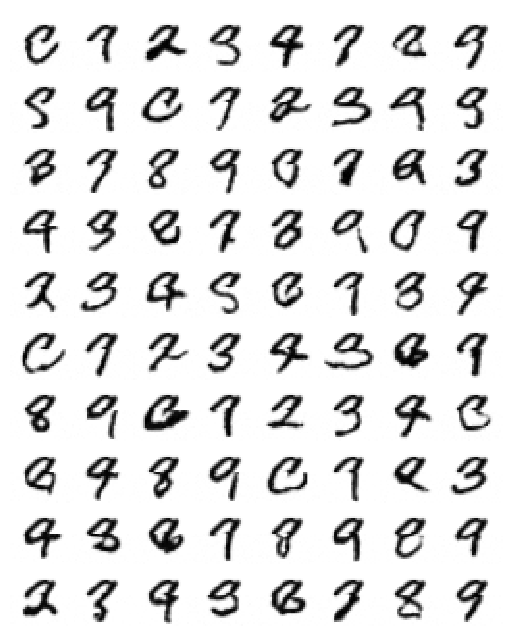

In [ ]:
with torch.no_grad():
    samples = diffusion.inpaint(images_known, mask_known, labels)
    samples01 = ((samples + 1) / 2).clip(0, 1)
    show_images(samples01[:80], cmap='binary', ncol=11)